## Check List 7 - MultiICP Detector
* **7.1 Kinect or Realsense**  
  - initialize, get_config, get_image, detect, add_model, compute_ICP, compute_front_ICP, disconnect  
  
  
* **TBD**
  - Auto initialization to estimate initial guess for ICP is not perfect
  - Robust and reliable initial guess for gloabl registration will be done

## Set running directory to Project source

In [1]:
import os
import sys
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.geometry.geometry import GeometryItem
from pkg.geometry.geotype import GEOTYPE
from pkg.detector.detector_interface import DetectionLevel

In [3]:
def add_cam(gscene, tool_link="indy0_tcp"):
    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name=tool_link,
                       dims=(0.061, 0.061, 0.026), center=(-0.0785, 0, 0.013), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.5), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name=tool_link,
                       dims=(0.081, 0.081, 0.046), center=(-0.0785, 0, 0.013), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)

    viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name=tool_link,
                                   dims=(0.01, 0.01, 0.01), center=(-0.013, 0, 0), rpy=(0, 0, -np.pi / 2),
                                   color=(1, 0, 0, 0.3), display=True, fixed=True, collision=False, parent="cam")

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name=tool_link,
                       dims=(0.067, 0.067, 0.0335), center=(-0.0785, 0, -0.01675), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 1), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name=tool_link,
                       dims=(0.087, 0.087, 0.0535), center=(-0.0785, 0, -0.01675), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)

    gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name=tool_link,
                       dims=(0.067, 0.067, 0.067), center=(-0.0785, 0, -0.0335), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 1), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name=tool_link,
                       dims=(0.087, 0.087, 0.087), center=(-0.0785, 0, -0.0335), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)
    return viewpoint

In [4]:
crob = CombinedRobot(robots_on_scene=[RobotConfig(0, RobotType.indy7, 
                           ((0,0,0), (0,0,0)),None)]
              , connection_list=[False])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
viewpoint = add_cam(gscene, tool_link="indy0_tcp")
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
gscene.show_pose(VIEW_POSE)
Tbc = viewpoint.get_tf(VIEW_POSE)

connection command:
indy0: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


## 2.1 Kinect or Realsense

In [3]:
from pkg.detector.multiICP.multiICP import MultiICP
from pkg.detector.camera.kinect import Kinect
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

##### create multiICP instance

In [4]:
micp = MultiICP(RealSense())
# micp = MultiICP(Kinect())

##### initialize()

In [5]:
micp.initialize()

Start streaming
Initialize Done


### Set MultiICP configs

In [ ]:
micp_dict = {"cup": micp_cup, "bed": micp_bed}
hrule_dict = {"closet": lambda objectPose_dict, micp: }
micp.set_config(micp_dict, hrule_dict)

##### get_config()
* This should return camera matrix (3x3) and distortion coefficients (4, 5, or 8 element vector).
* Distortion coefficients for RealSense is [0,0,0,0,0]
* Depth scale is scale value of depth image

In [6]:
camera_matrix, dist_coeffs, depth_scale = micp.get_camera_config()
print("camera_matrix: {} \n {}".format(camera_matrix.shape, camera_matrix))
print("dist_coeffs: {} \n {}".format(dist_coeffs.shape, dist_coeffs))
print("depth_scale:  \n {}".format(depth_scale))

camera_matrix: (3, 3) 
 [[899.05322266   0.         654.88366699]
 [  0.         899.21044922 352.92956543]
 [  0.           0.           1.        ]]
dist_coeffs: (5,) 
 [ 0.15870179 -0.46903715 -0.0014261   0.00066797  0.41631824]
depth_scale:  
 0.000250000011874


##### get_image()
* This will return camera image (RGB order), depth image

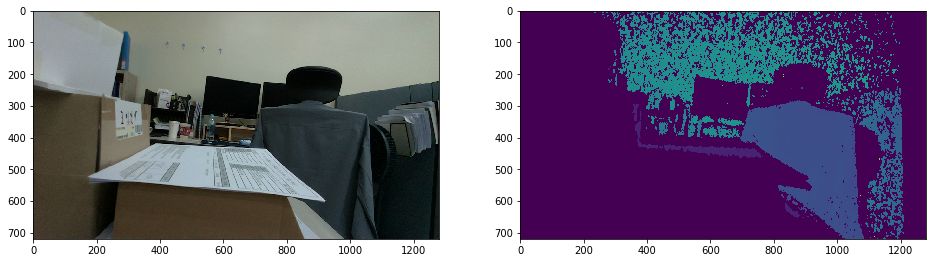

In [7]:
color_image, depth_image = micp.get_image()
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(color_image[:,:,[2,1,0]]) # Transpose in the last dimension is for RGB-to-BGR conversion. (plt.imshow shows image in BGR order)
plt.subplot(122)
plt.imshow(depth_image)

##### add_model()
* model_path is the path of CAD model you want to recognize and match
* Toff is GeometryItem coordinate in TriangleMesh coordinate
* scale value between CAD model and rviz dimension

In [14]:
from pkg.utils.rotation_utils import *

In [15]:
model_path = '/home/jhkim/Projects/rnb-planning/release/cup.stl'
Toff = SE3(np.identity(3), (0,0,0))
scale = [1.3,1.3,1.26]

# scale = [1e-3,1e-3,1e-3]

micp.add_model(model_path, Toff, scale)

In [8]:
micp_cup = MultiICP(RealSense())
micp_bed = MultiICP(RealSense())
micp_closet = MultiICP(RealSense())

In [9]:
micp_dict = {"cup": micp_cup, "bed": micp_bed, "closet": micp_closet}

In [10]:
# hrule_dict = {"closet": lambda objectPose_dict, micp_closet: }

In [20]:
hrule_dict = {"closet": lambda micp_closet, micp_bed, mrule_closet, objectPose_dict:
              hrule_closet(micp_closet, micp_bed, mrule_closet, objectPose_dict)}

In [21]:
micp.set_config(micp_dict, hrule_dict)

In [13]:
def make_pcd(self, cdp_masked, Tc=None, ratio=0.5):
    if Tc is None:
            Tc = np.identity(4)
    pcd_cam = cdp2pcd(cdp_masked, depth_trunc=self.depth_trunc)
    pcd = cdp2pcd(cdp_masked, Tc=Tc, depth_trunc=self.depth_trunc)

    self.pcd_Tc_stack.append((pcd_cam, Tc, pcd))
    self.pcd = self.pcd_Tc_stack[0][2]
    for _pcd in self.pcd_Tc_stack[1:]:
        self.pcd += _pcd[2]
    if len(self.pcd_Tc_stack) > 1:
        self.pcd = self.pcd.uniform_down_sample(every_k_points=len(self.pcd_Tc_stack))
    self.model.compute_vertex_normals()
    self.model_sampled = self.model.sample_points_uniformly(
        number_of_points=int(len(np.array(self.pcd.points)) * ratio))
    # self.model_sampled = self.model.sample_points_poisson_disk(
    #                                             number_of_points=int(len(np.array(self.pcd.points) * ratio)))

In [14]:
def set_model(self, model_name):
    obj_info = get_obj_info()
    model_info = obj_info[model_name]
    if model_info.Toff is None:
        self.Toff = np.identity(4)
        self.Toff_inv = SE3_inv(self.Toff)
    else :
        self.Toff = model_info.Toff
        self.Toff_inv = SE3_inv(self.Toff)
        
    if isinstance(model_info.url, o3d.geometry.TriangleMesh):
        self.model = model
    elif isinstance(model_info.url, str):
        self.model = o3d.io.read_triangle_mesh(model_info.url)
        self.model.vertices = o3d.utility.Vector3dVector(
            np.asarray(self.model.vertices) * np.array([scale[0],scale[1],scale[2]]))
    else:
        raise (NotImplementedError("non available input for model : \n".format(model)))

In [15]:
def detect(self):
    color_image, depth_image = self.get_image()
    camera_mtx = self.config_list[0]
    cam_intrins = [self.img_dim[1], self.img_dim[0],
                   camera_mtx[0,0],camera_mtx[1,1],
                   camera_mtx[0,2],camera_mtx[1,2]]
    depth_scale = self.config_list[2]
    cdp = ColorDepthMap(color_image, depth_image, cam_intrins, depth_scale)
    
    # Output of inference(mask for detected object)
    mask_out_list = sd.inference(color_img=cdp.color)
    mask_dict = {}
    for idx in range(80):
        if np.any(mask_out_list[idx]):
            pass
        else:
            for name, value in class_dict.items():
                if value == idx:
                    mask_dict[name] = mask_out_list[value]
    
    objectPose_dict = {}
    hrule_targets_dict = {}
    for name, micp in self.micp_dict.items():
        if name in mask_dict:
            micp.clear()
            
            # add to micp
            micp.set_model(name)
            masks = mask_dict[name]
            for i_m, mask in enumerate(masks):
                cdp_masked = micp.apply_mask(cdp, mask)
                micp.make_pcd(cdp_masked)
                
                # Compute ICP
                T,_ = micp.compute_ICP()
                name_i = "{}_{:02}".format(name, i_m)
                objectPose_dict[name_i] = T
        elif name in self.hrule_dict:
            micp.clear()
            
            # add to micp
            micp.set_model(name)
            hrule_targets_dict[name] = self.hrule_dict[name]
        else:
            raise(RuntimeError("Detection rule undefined for {}".format(name)))
            
    for name, hrule in sorted(hrule_targets_dict.items()):
        micp = self.micp_dict[name]
        
        # add to micp
        micp.set_model(name)
        pcd_dict = hrule.apply_rule(micp.pcd, objectPose_dict)
        T_list = []
        for name_i, pcd in pcd_dict.items():
            micp.pcd = pcd
            T,_ = micp.compute_ICP()
            T_list.append(T)
        for i_t, T in enumerate(T_list):
            name_i = "{}_{:02}".format(name, i_t)
            objectPose_dict[name_i] = T
            
    return objectPose_dict

In [16]:
def get_geometry_kwargs(self, name):
    if "_" in name:
        name_cat = name.split("_")[0]
    else:
        name_cat = name
    model = self.micp_dict[name_cat].model
    return dict(gtype=GEOTYPE.MESH, name=name_cat,
                dims=(0.1, 0.1, 0.1), color=(0.8, 0.8, 0.8, 1),
                display=True, fixed=True, collision=False,
                vertices=np.asarray(model.vertices), triangles=np.asarray(model.triangles))

In [17]:
class MaskBox:
    def __init__(self, Toff, dims, include):
        self.Toff, self.dims, self.include = Toff, dims, include
    
    def get_tf(self, Tparent):
        return np.matmul(Tparent, self.Toff)
    
    
class MaskBoxRule:
    def __init__(self, target, parent, merge_rule=np.all):
        self.target = target
        self.parent = parent
        self.box_list = []
        self.merge_rule = merge_rule
    
    def add_box(self, mbox):
        self.box_list.append(mbox)
        
    def apply_rule(self, pcd_in, objectPose_dict):
        pcd_dict = {}
        for oname, To in sorted(objectPose_dict.items()):
            pcd = copy.deepcopy(pcd_in)
            points = np.asarray(pcd.points)
            points4d = np.pad(points, ((0, 0), (0, 1)), 'constant', constant_values=1)
            mask_list = []
            for mbox in self.box_list:
                if self.parent in oname:
                    T_bx = mbox.get_tf(To)
                    T_xb = SE3_inv(T_bx)
                    abs_cuts = np.divide(mbox.dims, 2)
                    points_x = np.matmul(points4d, T_xb.transpose())[:, :3]
                    if mbox.inside:
                        mask = np.all(np.abs(points_x) < abs_cuts, axis=-1)
                    else:
                        mask = np.any(np.abs(points_x) > abs_cuts, axis=-1)
                    mask_list.append(mask)
            idc = np.where(self.merge_rule(mask_list, axis=0))[0]
            pcd.points = o3d.utility.Vector3dVector(points[idc])
            pcd_dict[oname.replace(self.parent, self.target)] = pcd
        return pcd_dict

In [ ]:
def check_closet_location(pcd_total, pcd_bed, T_bc, T_bo, bed_dims, floor_margin=0.1, visualize=False):
    pcd_total = pcd_total.uniform_down_sample(every_k_points=11)
    if visualize:
        o3d.visualization.draw_geometries([pcd_total])

    # Remove bed
    pcd_top_table = o3d.geometry.PointCloud()
    pcd_top_table.points = o3d.utility.Vector3dVector(remove_bed(pcd_total, pcd_bed))
    if visualize:
        o3d.visualization.draw_geometries([pcd_top_table])

    # Remove other noise
    cl, ind = pcd_top_table.remove_radius_outlier(nb_points=25, radius=0.15)
    pcd_top_table = cl
    if visualize:
        o3d.visualization.draw_geometries([pcd_top_table])

    # Determine rough location of top_table
    points = np.asarray(pcd_top_table.points)
    points_4d = []
    points_temp = []
    points_transformed = []
    for i in range(len(points)):
        points_4d.append(np.hstack([points[i], [1]]))

    for i in range(len(points_4d)):
        points_temp.append(np.matmul(T_bc, points_4d[i]))

    for i in range(len(points_temp)):
        points_transformed.append(np.matmul(np.linalg.inv(T_bo), points_temp[i]))

    points_transformed_np = np.array(points_transformed)[:,:3]

    # Remove background based on bed_vis coord
    out_x = np.where(np.abs(points_transformed_np[:,0])>bed_dims[0]/2)[0]
    out_y = np.where(np.abs(points_transformed_np[:,1])>bed_dims[1]/2+bed_dims[1])[0]
    out_z = np.where(points_transformed_np[:,2]<floor_margin)[0]
    out_all = sorted(set(out_x).union(out_y).union(out_z))
    in_all = sorted(set(np.arange(len(points_transformed_np))) - set(out_all))
    points_transformed = np.array(points_transformed)[in_all, :3]

    if visualize:
        vis_pointcloud_np(points_transformed)

    # Determine closet location by checking num of points
    check_left = 0
    check_right = 0
    for i in range(len(points_transformed)):
        if points_transformed[i][1] > 0:
            check_right += 1
        elif points_transformed[i][1] < 0:
            check_left += 1

    TOP_TABLE_MODE = "LEFT"
    if check_left > check_right:
        TOP_TABLE_MODE = "LEFT"
    else:
        TOP_TABLE_MODE = "RIGHT"

    return TOP_TABLE_MODE

In [18]:
def hrule_closet(micp_closet, micp_bed, mrule_closet, objectPose_dict):
    bed_dims = micp_bed
    Tbc = SE3(np.identity(3),(0,0,0))
    Tbo = micp_bed.pose
    CLOSET_LOCATION = check_closet_location(micp_closet.pcd, micp_bed.pcd, Tbc, Tbo, bed_dims)
    
    # bed_box
    mrule_closet.add_box(MaskBox(Toff=micp_bed.pose + SE3(np.identity(3), (0.02, 0, 0.5)),
                          dims=(3,1.6,1.3), include=False))
    # bed_walldg
    dg
    mrule_closet.add_box(MaskBox(Toff=micp_bed.pose + SE3(np.identity(3), (-1.27,0,1.5)),
                          dims=(0.5,0.7,0.3), include=False))
    # floor_box
    mrule_closet.add_box(MaskBox(Toff=SE3(np.identity(3), (0,0,0)), dims=(15,15,0.4), include=False))
    
    if CLOSET_LOCATION == "LEFT":
        # bed_left_space
        mrule_closet.add_box(MaskBox(Toff=micp_bed.pose+ SE3(np.identity(3), (0.02, -0.9, 1)), 
                                     dims=(2.5, 1, 3), include=True))
    elif CLOSET_LOCATION == "RIGHT":
        # bed_right_space
        mrule_closet.add_box(MaskBox(Toff=micp_bed.pose + SE3(np.identity(3), (0.02, 0.9, 1)), 
                                     dims=(2.5, 1, 3), include=True))

    return mrule_closet

In [19]:
mrule_closet = MaskBoxRule("closet", "bed", merge_rule=np.all)

In [23]:
name = "cup"
model = micp.model
obj_center = (1,1,1.2)
obj_rpy = (0,0,0)
gscene.create_safe(gtype=GEOTYPE.MESH, name="{}_res".format(name), link_name="base_link",
                   dims=(0.1,0.1,0.1), center=obj_center, rpy=obj_rpy,
                   color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False,
                   vertices=np.asarray(model.vertices), triangles=np.asarray(model.triangles))

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


In [22]:
model.vertices

std::vector<Eigen::Vector3d> with 1572864 elements.
Use numpy.asarray() to access data.

##### to visulize CAD model in Rviz
* Put the STL file rnb-planning/ws_ros/src/mymesh/meshes/stl and set uri="package://my_mesh/meshes/stl/{object.STL} in below code
* Then build the folder (Check the build custom workspace section in ReadMe.md)

In [12]:
def add_object(gscene, name, obj_center, obj_rpy, COLOR_TOILET_COL):
    gtem = gscene.create_safe(GEOTYPE.MESH, "{}".format(name), link_name="base_link",
                             dims=(0.1,0.1,0.1), center=obj_center, rpy=obj_rpy,
                             color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False,
                             uri="package://my_mesh/meshes/stl/cup.stl", scale=(1.3,1.3,1.26))

    return gtem

##### Run shared detector for object detection on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/pkg/detector/multiICP/shared_detector.py --dims='(720,1280,3)'
```

#### Clearing shared detector channels if zombie memory remains
```python
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")
```

In [9]:
from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(micp.img_dim+(3,))()
sd.init()

##### detect()
* Object Detection through swin-transformer based mask rcnn using mmdet
* obj_name is name of object you want to detect, which follows coco dataset class
* Tc is camera transformation matrix w.r.t base coordinate.

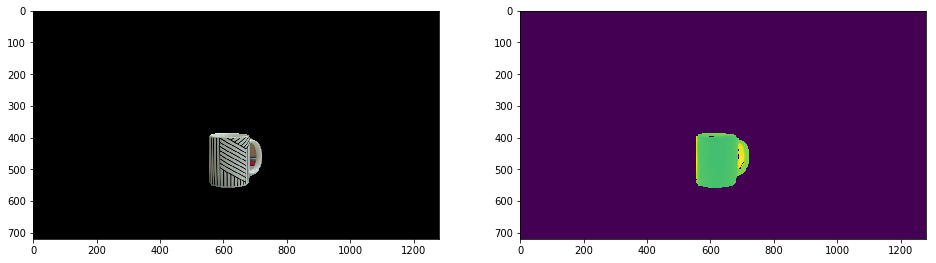

In [36]:
obj_name = 'cup'
color_masked = micp.detect(sd, obj_name)
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(color_masked[:,:,[2,1,0]]) # Transpose in the last dimension is for RGB-to-BGR conversion. (plt.imshow shows image in BGR order)
plt.subplot(122)
plt.imshow(micp.cdp.depth)

##### show on Rviz

In [37]:
Tbc = SE3(np.identity(3), (0,0,0))

In [38]:
pcd = micp.pcd
gscene.create_safe(GEOTYPE.MESH, "pcd", "base_link", (0.1,0.1,0.1), (0,0,0), rpy=(0,0,0), color=(1,0,0,1), display=True,
                   collision=False, fixed=True, scale=(0.01,0.01,1),
                   vertices=np.matmul(np.asarray(pcd.points), Tbc[:3,:3].transpose())+Tbc[:3,3])

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


##### compute_ICP()
* Initial guess is cruical for ICP
* Manual Initialization is needed to compute ICP well

In [39]:
Tguess = micp.get_initial_by_center(R=Rot_axis(1,np.pi/2),
                                        offset=(0.0,0,0.0))
ICP_result, fitness = micp.compute_ICP(To=Tguess, visualize=True)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.509968e-02, and correspondence_set size of 12485
Access transformation to get result.
Transformation is:
[[ 0.99930935  0.02409145  0.02829193 -0.02631322]
 [ 0.02880117 -0.02106007 -0.99936328  0.11347948]
 [-0.02348028  0.99948791 -0.02173939  0.55053717]
 [ 0.          0.          0.          1.        ]]


##### update at gsene

In [31]:
gtem = add_object(gscene, 'cup', ICP_result[:3,3], Rot2rpy(ICP_result[:3,:3]), (0,1,0,0.5))

##### compute_front_ICP()

In [31]:
ICP_result, fitness = micp.compute_front_ICP(visualize=True)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.120181e-02, and correspondence_set size of 7835
Access transformation to get result.
Transformation is:
[[ 0.98817746 -0.15291306  0.01108604 -0.02265138]
 [ 0.0080556  -0.02042342 -0.99975897  0.11835813]
 [ 0.15310262  0.98802858 -0.01895016  0.56058038]
 [ 0.          0.          0.          1.        ]]


##### update at gscene

In [19]:
gtem = add_object(gscene, 'cup', ICP_result[:3,3], Rot2rpy(ICP_result[:3,:3]), (0,1,0,0.5))

##### check geometry()

In [20]:
print("Detect by Levels")
print("Environments: {}".format(micp.get_targets_of_levels(gscene, DetectionLevel.ENVIRONMENT)))
print("Movable Objects: {}".format(micp.get_targets_of_levels(gscene, DetectionLevel.MOVABLE)))

Detect by Levels
Environments: []
Movable Objects: ['cup']


##### get pose()

In [21]:
print("Detect by Names")
print("{}: {}".format('cup', micp.get_pose('cup')))

Detect by Names
cup: [[ 0.66469009  0.71242562  0.22502627  0.03667995]
 [-0.3111956   0.53782571 -0.78351822  0.11671659]
 [-0.67922337  0.45076961  0.57919114  0.66397102]
 [ 0.          0.          0.          1.        ]]


##### disconnect()

In [22]:
micp.disconnect()